In [181]:
import pandas as pd
import numpy as np
import seaborn as sb
import torch
import torch.nn as nn
from time import time
import math
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
patient_pd = pd.read_csv('/content/FeverIQ_PatientData.csv')
patient_pd

,Unnamed: 0,cold,flu,corona,corona_silent,corona_test_result,created_at,country
0,3161,0.0,0.1,0.1,0.0,False,2020-05-06,SI
1,3169,0.1,1.0,0.5,0.0,True,2020-05-06,CN
2,3174,2.7,4.7,3.6,1.0,True,2020-05-06,CN
3,3186,0.0,0.1,0.1,0.0,True,2020-05-06,VN
4,3243,2.0,1.0,0.5,1.0,False,2020-05-06,US
...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8199,1033151,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8200,1033152,0.0,1.0,1.0,0.0,False,2020-06-30,ID
8201,1033155,0.1,0.1,0.5,1.0,False,2020-06-30,EG


In [3]:
patient_pd = patient_pd.rename(columns = {'Unnamed: 0':'id'})

In [4]:
patient_vis = patient_pd.drop(columns=['id'])
patient_vis.drop_duplicates()
patient_vis

,cold,flu,corona,corona_silent,corona_test_result,created_at,country
0,0.0,0.1,0.1,0.0,False,2020-05-06,SI
1,0.1,1.0,0.5,0.0,True,2020-05-06,CN
2,2.7,4.7,3.6,1.0,True,2020-05-06,CN
3,0.0,0.1,0.1,0.0,True,2020-05-06,VN
4,2.0,1.0,0.5,1.0,False,2020-05-06,US
...,...,...,...,...,...,...,...
8198,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8199,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8200,0.0,1.0,1.0,0.0,False,2020-06-30,ID
8201,0.1,0.1,0.5,1.0,False,2020-06-30,EG


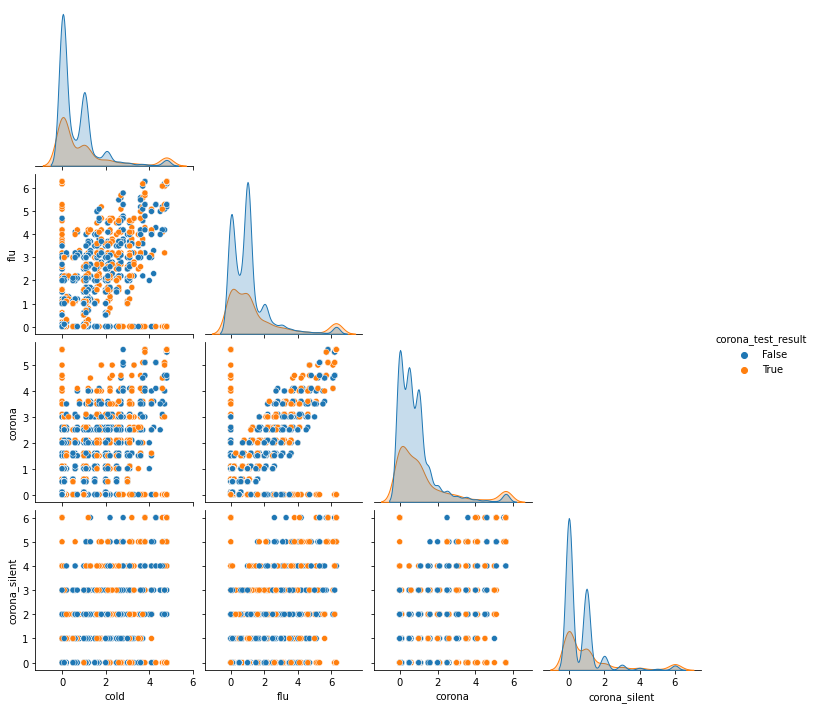

In [5]:
vis = sb.pairplot(data=patient_vis, hue='corona_test_result', corner=True)

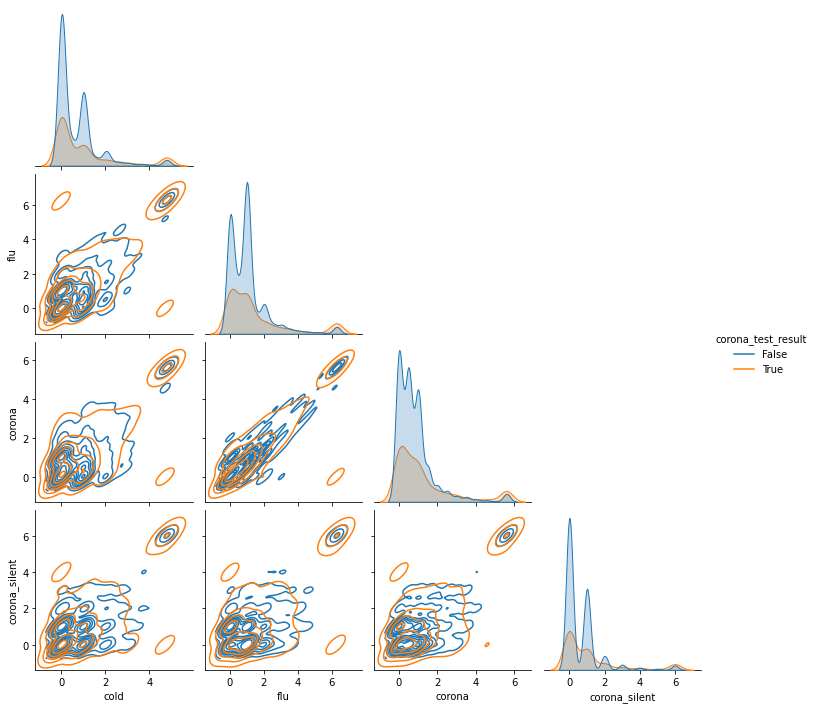

In [6]:
vis2 = sb.pairplot(data=patient_vis, hue='corona_test_result', corner=True, kind="kde")

In [7]:
patient_onehot_df = pd.get_dummies(patient_pd, columns=['country'])

In [8]:
patient_onehot_df['created_at'] = pd.to_datetime(patient_onehot_df['created_at'], infer_datetime_format=True)
patient_df2 = patient_onehot_df

In [9]:
start_date = patient_onehot_df['created_at'][0]

In [10]:
patient_onehot_df['created_at'] = patient_onehot_df['created_at'].apply(lambda x: (x - start_date).days)

In [11]:
patient_onehot_df

,id,cold,flu,corona,corona_silent,corona_test_result,created_at,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,...,country_PG,country_PH,country_PK,country_PL,country_PR,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM
0,3161,0.0,0.1,0.1,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3169,0.1,1.0,0.5,0.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3174,2.7,4.7,3.6,1.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3186,0.0,0.1,0.1,0.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3243,2.0,1.0,0.5,1.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8199,1033151,0.2,1.1,1.5,1.0,True,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8200,1033152,0.0,1.0,1.0,0.0,False,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8201,1033155,0.1,0.1,0.5,1.0,False,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
xTrain = patient_onehot_df.drop(columns=['id','corona_test_result'])
yTrain = patient_onehot_df['corona_test_result']

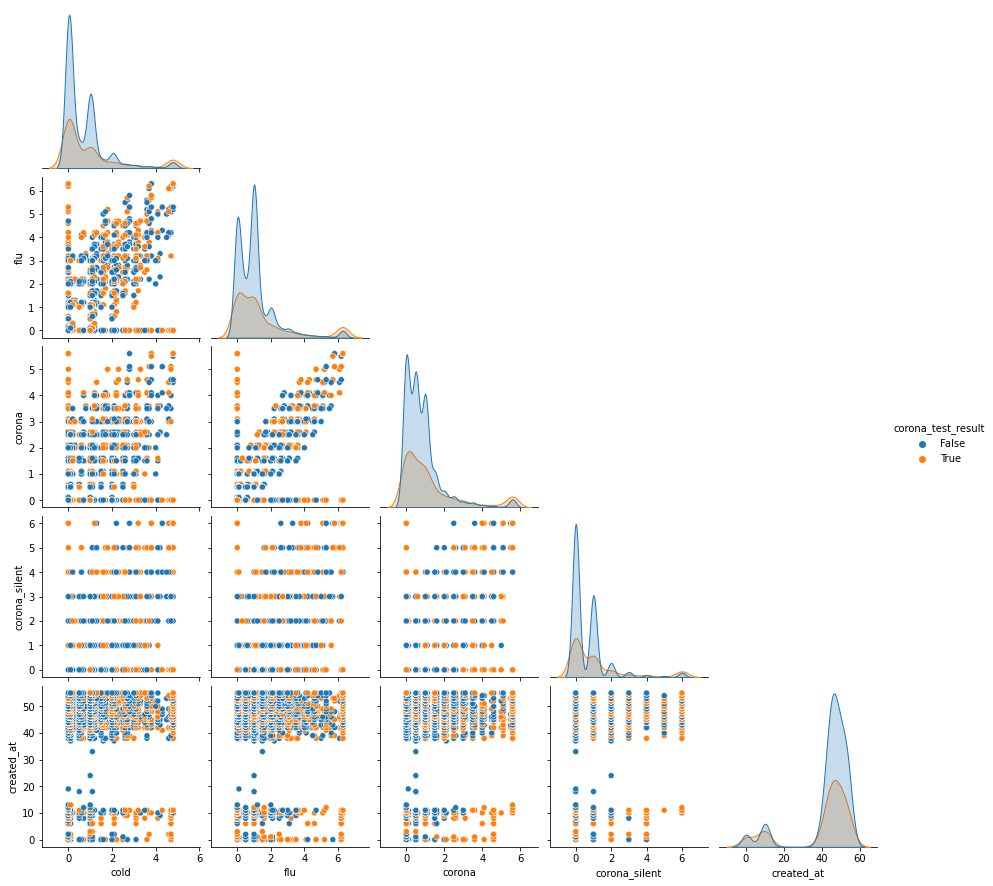

In [13]:
vis3 = sb.pairplot(data=patient_onehot_df[['cold','flu','corona','corona_silent','corona_test_result','created_at']], hue='corona_test_result', corner=True)

In [14]:
class PredictionModel(nn.Module):

    def __init__(self, dim, bias):

        super(PredictionModel, self).__init__()
        self.bias = bias
        self.bn = nn.BatchNorm1d(dim[0])
        fc = []
        for i in range(len(dim) - 2):
          fc.append(nn.Linear(dim[i], dim[i+1],bias=self.bias))
          fc.append(nn.ReLU())
        fc.append(nn.Linear(dim[-2],dim[-1],bias=self.bias))
        fc.append(nn.Sigmoid())
        self.linear = nn.Sequential(*fc)

    def forward(self, x):
        out = self.linear(self.bn(x))
        return out

In [15]:
hyperam = [140, 50, 10, 1]

In [16]:
torch.set_default_dtype(torch.float64)
model = PredictionModel(hyperam, True)

criterion = nn.L1Loss()
learing_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

epochs = 3000

In [17]:
xTrain_tensor = torch.tensor(xTrain.values).double()
xTrain_nocountry_tensor = xTrain_tensor[:,:5]
yTrain_tensor = torch.tensor(yTrain.values).double().unsqueeze(1)

In [18]:
xTrain_tensor.dtype

torch.float64

In [19]:
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model.forward(xTrain_tensor)
    loss = criterion(outputs, yTrain_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.5004813178875359
epoch 100, loss 0.2953628159126038
epoch 200, loss 0.26872053571751336
epoch 300, loss 0.2652276065985759
epoch 400, loss 0.26276636636897427
epoch 500, loss 0.26045993024966646
epoch 600, loss 0.2585592344520492
epoch 700, loss 0.25701785331419674
epoch 800, loss 0.25562043451134014
epoch 900, loss 0.25447364139169765
epoch 1000, loss 0.2534799079153072
epoch 1100, loss 0.2524797413975843
epoch 1200, loss 0.25186621033319734
epoch 1300, loss 0.25129267742349237
epoch 1400, loss 0.2507813820604788
epoch 1500, loss 0.2501886609773313
epoch 1600, loss 0.24968935884677218
epoch 1700, loss 0.24942782653537218
epoch 1800, loss 0.24919814653059422
epoch 1900, loss 0.24897387796857398
epoch 2000, loss 0.2484617126632325
epoch 2100, loss 0.24832482810344478
epoch 2200, loss 0.24821693710009987
epoch 2300, loss 0.24800647099785278
epoch 2400, loss 0.2479317024276141
epoch 2500, loss 0.24778588193689013
epoch 2600, loss 0.24770583220964548
epoch 2700, loss 0.2476

In [20]:
vis_result = pd.DataFrame(outputs.data, columns=['predicted']).astype("float")
vis_result['actual'] = pd.DataFrame(yTrain_tensor.data).astype("float")
vis_result

,predicted,actual
0,3.858410e-12,0.0
1,1.000000e+00,1.0
2,1.000000e+00,1.0
3,1.000000e+00,1.0
4,5.545919e-05,0.0
...,...,...
8198,1.000000e+00,1.0
8199,1.000000e+00,1.0
8200,6.033885e-20,0.0
8201,1.847293e-24,0.0


In [21]:
roc_auc_score(vis_result['actual'], vis_result['predicted'])

0.7450997046200405

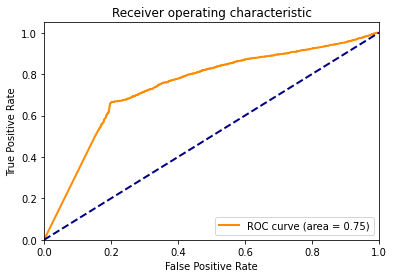

In [22]:
fpr, tpr, _ = roc_curve(vis_result['actual'], vis_result['predicted'])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

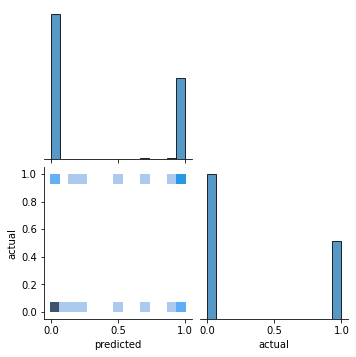

In [23]:
sb.pairplot(vis_result, kind='hist', corner=True)

Second Trial

In [24]:
patient_df2

,id,cold,flu,corona,corona_silent,corona_test_result,created_at,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,...,country_PG,country_PH,country_PK,country_PL,country_PR,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM
0,3161,0.0,0.1,0.1,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3169,0.1,1.0,0.5,0.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3174,2.7,4.7,3.6,1.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3186,0.0,0.1,0.1,0.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3243,2.0,1.0,0.5,1.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8199,1033151,0.2,1.1,1.5,1.0,True,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8200,1033152,0.0,1.0,1.0,0.0,False,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8201,1033155,0.1,0.1,0.5,1.0,False,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
patient_pd

,id,cold,flu,corona,corona_silent,corona_test_result,created_at,country
0,3161,0.0,0.1,0.1,0.0,False,2020-05-06,SI
1,3169,0.1,1.0,0.5,0.0,True,2020-05-06,CN
2,3174,2.7,4.7,3.6,1.0,True,2020-05-06,CN
3,3186,0.0,0.1,0.1,0.0,True,2020-05-06,VN
4,3243,2.0,1.0,0.5,1.0,False,2020-05-06,US
...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8199,1033151,0.2,1.1,1.5,1.0,True,2020-06-30,VN
8200,1033152,0.0,1.0,1.0,0.0,False,2020-06-30,ID
8201,1033155,0.1,0.1,0.5,1.0,False,2020-06-30,EG


In [26]:
patient_onehot_df = pd.get_dummies(patient_pd, columns=['country'])
patient_onehot_df['created_at'] = pd.to_datetime(patient_onehot_df['created_at'], infer_datetime_format=True)
patient_df2 = patient_onehot_df
patient_df2['Day_in_week']=patient_df2['created_at'].apply(lambda x: x.weekday())

In [27]:
patient_df2['Day_in_week_x'] = patient_df2['Day_in_week'].apply(lambda x: np.sin(2*np.pi*x/7))
patient_df2['Day_in_week_y'] = patient_df2['Day_in_week'].apply(lambda x: np.cos(2*np.pi*x/7))
patient_df2

,id,cold,flu,corona,corona_silent,corona_test_result,created_at,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,...,country_PL,country_PR,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM,Day_in_week,Day_in_week_x,Day_in_week_y
0,3161,0.0,0.1,0.1,0.0,False,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521
1,3169,0.1,1.0,0.5,0.0,True,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521
2,3174,2.7,4.7,3.6,1.0,True,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521
3,3186,0.0,0.1,0.1,0.0,True,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.974928,-0.222521
4,3243,2.0,1.0,0.5,1.0,False,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.781831,0.623490
8199,1033151,0.2,1.1,1.5,1.0,True,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.781831,0.623490
8200,1033152,0.0,1.0,1.0,0.0,False,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.781831,0.623490
8201,1033155,0.1,0.1,0.5,1.0,False,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.781831,0.623490


In [28]:
patient_df2['Day_since_first']=patient_df2['created_at'].apply(lambda x: (x - start_date).days)
patient_df2

,id,cold,flu,corona,corona_silent,corona_test_result,created_at,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,...,country_PR,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM,Day_in_week,Day_in_week_x,Day_in_week_y,Day_since_first
0,3161,0.0,0.1,0.1,0.0,False,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
1,3169,0.1,1.0,0.5,0.0,True,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
2,3174,2.7,4.7,3.6,1.0,True,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
3,3186,0.0,0.1,0.1,0.0,True,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.974928,-0.222521,0
4,3243,2.0,1.0,0.5,1.0,False,2020-05-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,1033149,0.2,1.1,1.5,1.0,True,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.781831,0.623490,55
8199,1033151,0.2,1.1,1.5,1.0,True,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.781831,0.623490,55
8200,1033152,0.0,1.0,1.0,0.0,False,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.781831,0.623490,55
8201,1033155,0.1,0.1,0.5,1.0,False,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.781831,0.623490,55


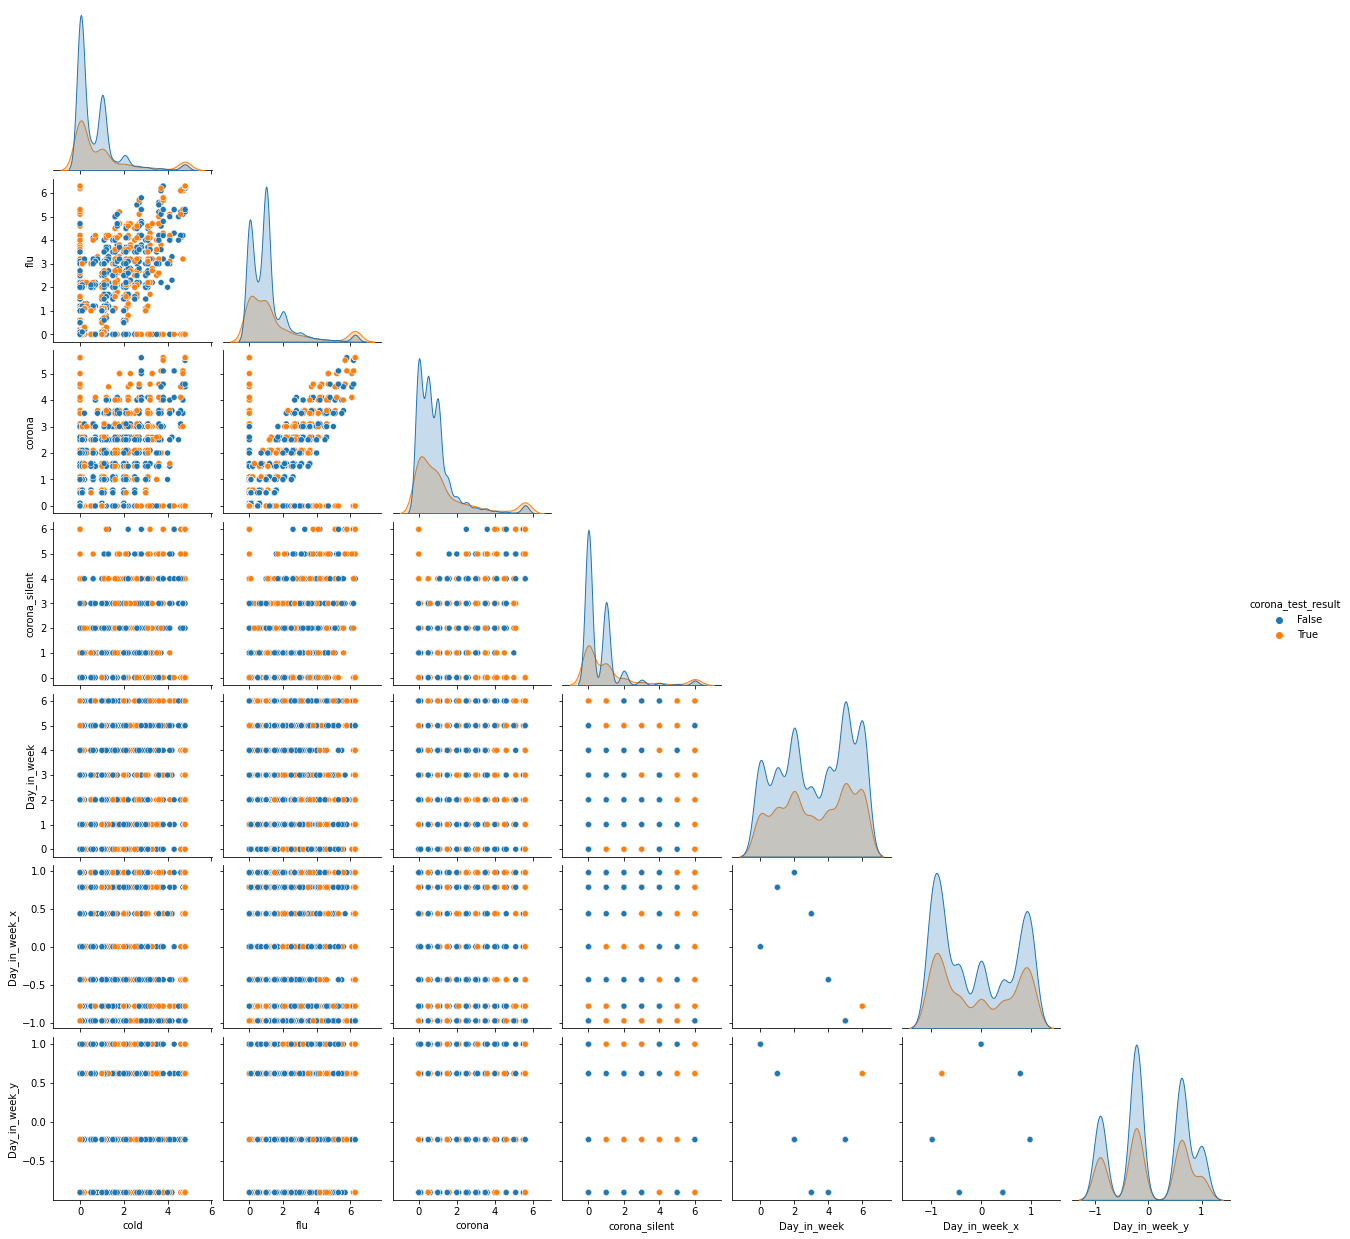

In [29]:
vis4 = sb.pairplot(data=patient_df2[['cold','flu','corona','corona_silent','corona_test_result','created_at', 'Day_in_week','Day_in_week_x','Day_in_week_y']], hue='corona_test_result', corner=True)

In [30]:
testratio = 0.1
num_test = math.floor(testratio * patient_df2.shape[0])
num_test

820

In [31]:
xTrain2 = patient_df2.drop(columns=['id','corona_test_result','created_at'])
xTrain2 = xTrain2[:-num_test]
yTrain2 = patient_df2['corona_test_result'][:-num_test]

xTrain_tensor2 = torch.tensor(xTrain2.values).double()
display(xTrain2)
xTrain_nocountry_nodate_tensor2 = xTrain_tensor2[:,:4] #torch.cat((xTrain_tensor2[:,:5], xTrain_tensor2[:,-7:]),dim=1)
xTrain_nodate_tensor2 = xTrain_tensor2[:,:-4]
yTrain_tensor2 = torch.tensor(yTrain2.values).double().unsqueeze(1)

,cold,flu,corona,corona_silent,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,country_DO,country_DZ,country_EC,...,country_PR,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM,Day_in_week,Day_in_week_x,Day_in_week_y,Day_since_first
0,0.0,0.1,0.1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
1,0.1,1.0,0.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
2,2.7,4.7,3.6,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
3,0.0,0.1,0.1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0.974928,-0.222521,0
4,2.0,1.0,0.5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.974928,-0.222521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7378,0.5,1.0,0.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,-0.781831,0.623490,53
7379,0.0,1.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-0.781831,0.623490,53
7380,0.1,0.1,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-0.781831,0.623490,53
7381,1.0,1.0,0.5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-0.781831,0.623490,53


In [32]:
selected = xTrain_nodate_tensor2
feature_in = selected.shape[1]
feature_in

139

In [83]:
class customLoss(torch.nn.Module):

    def __init__(self, weight=1):
      super().__init__()
      self.weight = weight

    def forward(self, input, target):
      epsilon = 10 ** -10
      input = input.clamp(epsilon, 1 - epsilon)

      #my_loss = -1 * (target * torch.log(input)
      #                    + self.pos_weight * (1 - target) * torch.log(1 - input))
      my_loss = torch.abs(input - target) + self.weight * (target * (1-input))
      mean_loss = my_loss.mean()
      return mean_loss

In [34]:
xTrain_tensor2.max()

tensor(53.)

In [84]:
torch.set_default_dtype(torch.float64)
model = PredictionModel([feature_in, 50, 10, 1], True)
criterion = customLoss(2)
learing_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model.forward(selected)
    loss = criterion(outputs, yTrain_tensor2)
    loss.backward()
    if torch.isnan(loss):
      print('Loss NaN')
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.8692710493639881
epoch 100, loss 0.4242615197097303
epoch 200, loss 0.4184322575404314
epoch 300, loss 0.4144584120142713
epoch 400, loss 0.4136933202295524
epoch 500, loss 0.4134381500787591
epoch 600, loss 0.41321213104478477
epoch 700, loss 0.4126999099136084
epoch 800, loss 0.4126497430495888
epoch 900, loss 0.4121195043613709


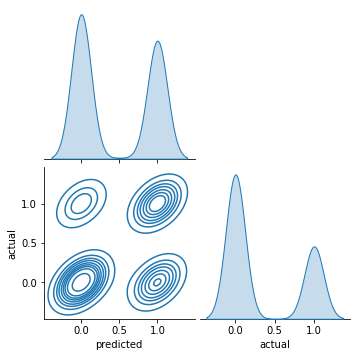

In [82]:
with torch.no_grad():
  xTest = torch.tensor(patient_df2.drop(columns=['id','corona_test_result','created_at'])[-num_test:].values).double()
  xTest_nocountry_nodate = xTest[:,:4]
  xTest_nodate = xTest[:,:-4]
  yTestHat = model.forward(xTest_nodate)
  vis_result3 = pd.DataFrame(yTestHat.data, columns=['predicted']).astype("float64")
  vis_result3['actual'] = pd.DataFrame(patient_df2['corona_test_result'][-num_test:].reset_index(drop=True)).astype("bool")

sb.pairplot(vis_result3, kind='kde', corner=True)

In [85]:
roc_auc_score(vis_result3['actual'], vis_result3['predicted'])

0.7458423571562257

In [69]:
vis_result3['predicted']

0      1.000000e+00
1      1.000000e+00
2      8.657212e-08
3      1.000000e+00
4      6.733778e-10
           ...     
815    1.000000e+00
816    1.000000e+00
817    2.015350e-11
818    2.547914e-14
819    9.631445e-14
Name: predicted, Length: 820, dtype: float64

In [62]:
predicted_bool = pd.DataFrame(yTestHat.data > 0.5).astype("bool")
predicted_bool

,0
0,False
1,True
2,False
3,True
4,False
...,...
815,True
816,True
817,False
818,True


In [63]:
vis_result4 = patient_df2[-num_test:].reset_index(drop=True)
vis_result4['predicted'] = predicted_bool
vis_result4

,id,cold,flu,corona,corona_silent,corona_test_result,created_at,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,...,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM,Day_in_week,Day_in_week_x,Day_in_week_y,Day_since_first,predicted
0,1031781,0.1,1.0,0.5,0.0,False,2020-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,-0.781831,0.62349,53,False
1,1031782,4.8,6.3,5.6,5.0,True,2020-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,-0.781831,0.62349,53,True
2,1031785,1.0,0.0,0.0,0.0,False,2020-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-0.781831,0.62349,53,False
3,1031787,0.0,0.0,0.0,1.0,True,2020-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,-0.781831,0.62349,53,True
4,1031793,2.5,2.5,1.5,2.0,True,2020-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-0.781831,0.62349,53,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,1033149,0.2,1.1,1.5,1.0,True,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.781831,0.62349,55,True
816,1033151,0.2,1.1,1.5,1.0,True,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.781831,0.62349,55,True
817,1033152,0.0,1.0,1.0,0.0,False,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.781831,0.62349,55,False
818,1033155,0.1,0.1,0.5,1.0,False,2020-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.781831,0.62349,55,True


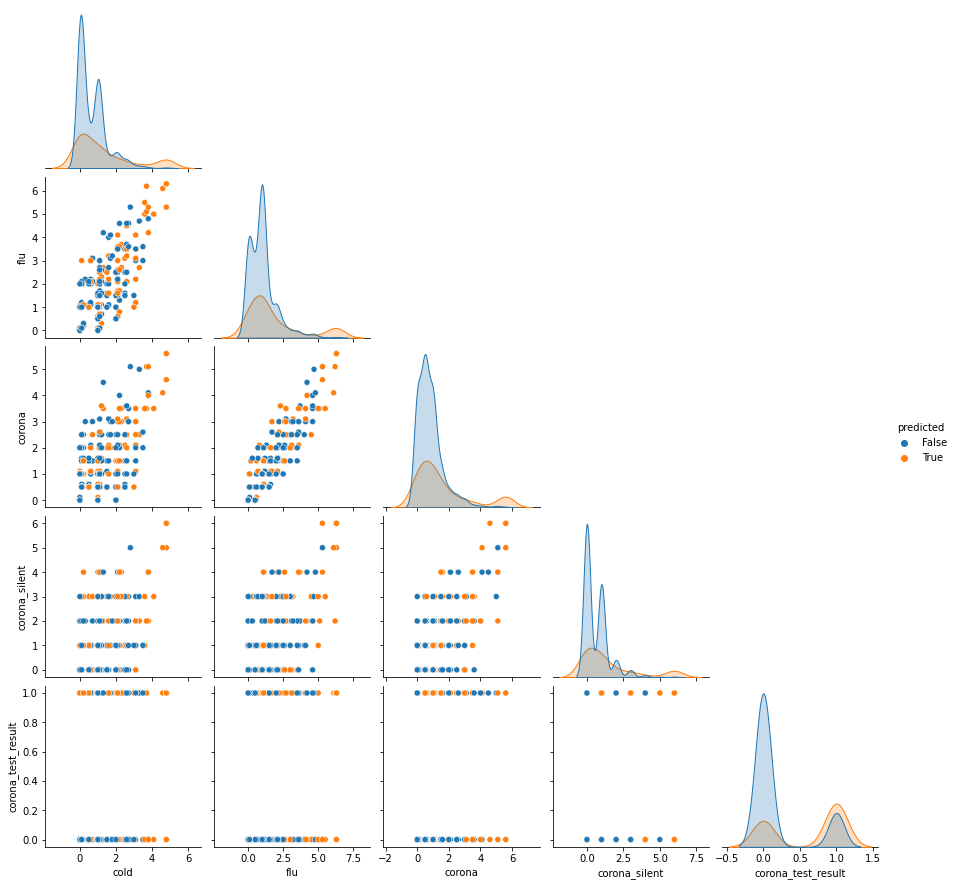

In [41]:
vis5 = sb.pairplot(data=vis_result4[['cold','flu','corona','corona_silent','corona_test_result','predicted']], hue='predicted', corner=True)

Visualization of ROC AUC

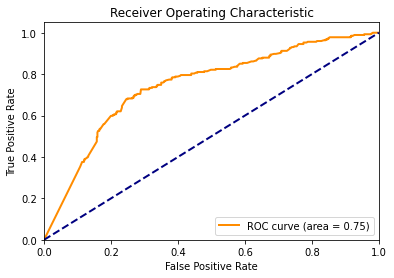

In [210]:
fpr, tpr, _ = roc_curve(vis_result3['actual'], vis_result3['predicted'])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Further Exploration

In [300]:
patient_onehot_df = pd.get_dummies(patient_pd, columns=['country'])
patient_onehot_df['created_at'] = pd.to_datetime(patient_onehot_df['created_at'], infer_datetime_format=True)
patient_df3 = patient_onehot_df
patient_df3 = patient_df3.drop(columns=['id', 'created_at'])
patient_df3

,cold,flu,corona,corona_silent,corona_test_result,country_AE,country_AF,country_AL,country_AR,country_AT,country_AU,country_AZ,country_BA,country_BD,country_BE,country_BF,country_BG,country_BH,country_BJ,country_BO,country_BR,country_BT,country_BY,country_CA,country_CD,country_CH,country_CI,country_CL,country_CM,country_CN,country_CR,country_CU,country_CW,country_CY,country_CZ,country_DE,country_DJ,country_DK,country_DO,country_DZ,...,country_PG,country_PH,country_PK,country_PL,country_PR,country_PS,country_PT,country_QA,country_RO,country_RS,country_RU,country_RW,country_SA,country_SC,country_SD,country_SE,country_SG,country_SH,country_SI,country_SJ,country_SK,country_SO,country_SY,country_TF,country_TG,country_TH,country_TN,country_TR,country_TW,country_TZ,country_UA,country_UG,country_US,country_UZ,country_VA,country_VE,country_VN,country_YE,country_ZA,country_ZM
0,0.0,0.1,0.1,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.1,1.0,0.5,0.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2.7,4.7,3.6,1.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.1,0.1,0.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2.0,1.0,0.5,1.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,0.2,1.1,1.5,1.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8199,0.2,1.1,1.5,1.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8200,0.0,1.0,1.0,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8201,0.1,0.1,0.5,1.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [230]:
(patient_df3['corona_test_result'] == False).sum()

5333

In [278]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','flu','corona','corona_silent', 'cold'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.744019566539566
epoch 100, loss 0.3788367188231331
epoch 200, loss 0.3788334547962287
epoch 300, loss 0.3788312929475932
epoch 400, loss 0.3788298112816028
epoch 500, loss 0.37882877334226733
epoch 600, loss 0.3788280284464806
epoch 700, loss 0.3788274721987945
epoch 800, loss 0.3788270486430693
epoch 900, loss 0.3788267180224763
epoch 0, loss 0.7499307118019525
epoch 100, loss 0.41824799326871875
epoch 200, loss 0.4182452384946606
epoch 300, loss 0.41824364899586974
epoch 400, loss 0.41824260358895554
epoch 500, loss 0.4182418835304567
epoch 600, loss 0.4182413615448432
epoch 700, loss 0.4182409689214615
epoch 800, loss 0.4182406619848333
epoch 900, loss 0.418240417637733
epoch 0, loss 0.744010598211072
epoch 100, loss 0.39940456416075926
epoch 200, loss 0.3994015486866789
epoch 300, loss 0.39939965067533106
epoch 400, loss 0.39939836188490746
epoch 500, loss 0.3993974656270097
epoch 600, loss 0.3993968060159409
epoch 700, loss 0.39939630525902514
epoch 800, loss 0.399

In [280]:
avg

0.6873837692305229

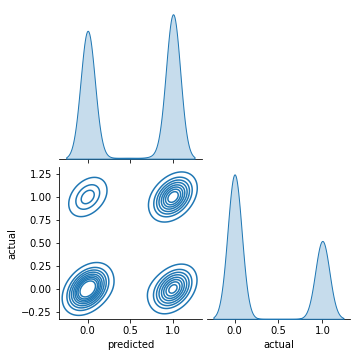

In [273]:
with torch.no_grad():
  xTest_tensor3 = torch.tensor(xTest3.values).double()
  yTestHat3 = model.forward(xTest_tensor3)
  vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
  vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")

sb.pairplot(vis_result5, kind='kde', corner=True)

In [218]:
vis_result5

,predicted,actual
0,1.176624e-23,False
1,1.000000e+00,True
2,1.000000e+00,True
3,9.999990e-01,True
4,1.346042e-05,False
...,...,...
7397,1.000000e+00,True
7398,1.000000e+00,True
7399,2.007695e-33,False
7400,1.692563e-25,False


In [249]:
roc_auc_score(vis_result5['actual'], vis_result5['predicted'])

0.5929741191899289

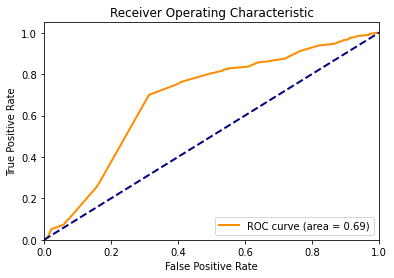

In [281]:
fpr, tpr, _ = roc_curve(vis_result5['actual'], vis_result5['predicted'])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

No Country information

In [282]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  #x3 = patient_df3.drop(columns=['corona_test_result','flu','corona','corona_silent', 'cold'])
  x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.7712003417090008
epoch 100, loss 0.5466925143548278
epoch 200, loss 0.5244917914131938
epoch 300, loss 0.5206820865880935
epoch 400, loss 0.51397606562322
epoch 500, loss 0.5131431116205026
epoch 600, loss 0.5125021144982
epoch 700, loss 0.5121126364783495
epoch 800, loss 0.5119255578520592
epoch 900, loss 0.5118282515289779
epoch 0, loss 0.7555381654796508
epoch 100, loss 0.5581921797354258
epoch 200, loss 0.5480956625703799
epoch 300, loss 0.5453709659868796
epoch 400, loss 0.5450043108236783
epoch 500, loss 0.5448602729243359
epoch 600, loss 0.544765128344064
epoch 700, loss 0.5446907343017463
epoch 800, loss 0.5446299126954262
epoch 900, loss 0.544582901747823
epoch 0, loss 0.7601050825069883
epoch 100, loss 0.602248711127013
epoch 200, loss 0.5918197264402433
epoch 300, loss 0.5845488016753042
epoch 400, loss 0.5835753561041264
epoch 500, loss 0.5809619138412614
epoch 600, loss 0.5807835321056949
epoch 700, loss 0.5806957039027857
epoch 800, loss 0.5806485257057274

In [283]:
avg

0.5853285627044248

In [284]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','flu'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.7403807467969823
epoch 100, loss 0.33758352297647065
epoch 200, loss 0.3297878959167895
epoch 300, loss 0.32636554620913694
epoch 400, loss 0.3261095830542934
epoch 500, loss 0.3260224728028808
epoch 600, loss 0.32598078456582974
epoch 700, loss 0.3259575793621224
epoch 800, loss 0.3259432668034354
epoch 900, loss 0.3256186099301877
epoch 0, loss 0.7779329343901333
epoch 100, loss 0.3505951977397076
epoch 200, loss 0.3480128904958545
epoch 300, loss 0.3465557086879675
epoch 400, loss 0.3462703726323549
epoch 500, loss 0.34619374978709266
epoch 600, loss 0.3461585986792495
epoch 700, loss 0.34614051114686134
epoch 800, loss 0.34726200405064767
epoch 900, loss 0.34371371541459345
epoch 0, loss 0.7634123224565733
epoch 100, loss 0.3279466708290815
epoch 200, loss 0.3187544022275133
epoch 300, loss 0.31135900049087867
epoch 400, loss 0.3110593176542972
epoch 500, loss 0.30776648000217666
epoch 600, loss 0.3046859263545868
epoch 700, loss 0.3046740037370589
epoch 800, loss 0

In [285]:
avg

0.7185523863775922

In [286]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','corona'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.7792158640894399
epoch 100, loss 0.3395970759538563
epoch 200, loss 0.3343347765676936
epoch 300, loss 0.3315498731637199
epoch 400, loss 0.33145151388849037
epoch 500, loss 0.3314238244687747
epoch 600, loss 0.331411240828387
epoch 700, loss 0.3314043893452943
epoch 800, loss 0.3314002822950228
epoch 900, loss 0.3313975431995163
epoch 0, loss 0.7626443880597101
epoch 100, loss 0.3777492270439409
epoch 200, loss 0.36896411323370115
epoch 300, loss 0.36466566649093257
epoch 400, loss 0.36067067550797854
epoch 500, loss 0.3603707647121295
epoch 600, loss 0.3602476141307974
epoch 700, loss 0.3601866418435491
epoch 800, loss 0.36015129272794133
epoch 900, loss 0.36012946577602334
epoch 0, loss 0.7604173239774363
epoch 100, loss 0.3294261241357564
epoch 200, loss 0.32831442385321524
epoch 300, loss 0.32823342152949164
epoch 400, loss 0.32820726217840185
epoch 500, loss 0.32390939244764677
epoch 600, loss 0.3232677034047967
epoch 700, loss 0.32140810935464814
epoch 800, loss 

In [287]:
avg

0.716144944532625

In [288]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','corona_silent'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.784081392512353
epoch 100, loss 0.3576993760169374
epoch 200, loss 0.34239874515563334
epoch 300, loss 0.33911813581831796
epoch 400, loss 0.33882975864396647
epoch 500, loss 0.3387360584009313
epoch 600, loss 0.33869272510044346
epoch 700, loss 0.33866873922265733
epoch 800, loss 0.33865395018750183
epoch 900, loss 0.3386441163455889
epoch 0, loss 0.7784473502217271
epoch 100, loss 0.35086119237962143
epoch 200, loss 0.3430442714237227
epoch 300, loss 0.33705729689491637
epoch 400, loss 0.33649559883200575
epoch 500, loss 0.3355860813523899
epoch 600, loss 0.3349831810689129
epoch 700, loss 0.3346742372532945
epoch 800, loss 0.33443904146123904
epoch 900, loss 0.3343239003632024
epoch 0, loss 0.7545324352241872
epoch 100, loss 0.3518475670386239
epoch 200, loss 0.341844826332002
epoch 300, loss 0.3411590650949392
epoch 400, loss 0.34099947879970377
epoch 500, loss 0.3421301841639077
epoch 600, loss 0.3397151274679276
epoch 700, loss 0.3397001898791136
epoch 800, loss 0

In [289]:
avg

0.7045085152378027

In [290]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','cold'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.7622121022980994
epoch 100, loss 0.34928974323597917
epoch 200, loss 0.34244665960616033
epoch 300, loss 0.3394851734579059
epoch 400, loss 0.33629135179413494
epoch 500, loss 0.33622844234382393
epoch 600, loss 0.3361971463954846
epoch 700, loss 0.33617883849116464
epoch 800, loss 0.33616749852881667
epoch 900, loss 0.33615883881727343
epoch 0, loss 0.7721578466970727
epoch 100, loss 0.33610677360783103
epoch 200, loss 0.3310358001340552
epoch 300, loss 0.327987561581523
epoch 400, loss 0.3277935732164079
epoch 500, loss 0.3276230286832002
epoch 600, loss 0.32944681125269754
epoch 700, loss 0.3330805703517986
epoch 800, loss 0.333034179811331
epoch 900, loss 0.33301279417368007
epoch 0, loss 0.7450098749982933
epoch 100, loss 0.3717087316561296
epoch 200, loss 0.363023089395744
epoch 300, loss 0.3624434425927516
epoch 400, loss 0.3590324745796161
epoch 500, loss 0.35602883141031705
epoch 600, loss 0.3559346312196483
epoch 700, loss 0.3558160371105378
epoch 800, loss 0.

In [291]:
avg

0.7204224248353415

In [292]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','corona', 'corona_silent'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.7577671035242003
epoch 100, loss 0.34789898190375207
epoch 200, loss 0.34705377726590814
epoch 300, loss 0.34694998663042403
epoch 400, loss 0.3468815528985001
epoch 500, loss 0.34689041254418534
epoch 600, loss 0.3537743727281837
epoch 700, loss 0.3512808449386144
epoch 800, loss 0.350995137602727
epoch 900, loss 0.3500920474854973
epoch 0, loss 0.7373863756515777
epoch 100, loss 0.38928495144083197
epoch 200, loss 0.38378941696736213
epoch 300, loss 0.38253951455866997
epoch 400, loss 0.3824322194492217
epoch 500, loss 0.3815188224546046
epoch 600, loss 0.377585014783512
epoch 700, loss 0.3775655567104897
epoch 800, loss 0.3775624517358608
epoch 900, loss 0.377560395449785
epoch 0, loss 0.7506334779756245
epoch 100, loss 0.3321647283608568
epoch 200, loss 0.3284051207498264
epoch 300, loss 0.32550782837615877
epoch 400, loss 0.3248428165507662
epoch 500, loss 0.3247306105724435
epoch 600, loss 0.32469399006943683
epoch 700, loss 0.3246777716553231
epoch 800, loss 0.32

In [294]:
avg

0.7100183035244889

In [307]:
aucscore = []
for i in range(10):
  testratio = 0.9
  num_test = math.floor(testratio * patient_df3.shape[0])
  ind = np.random.rand(len(patient_df3)) < 1 - testratio
  x3 = patient_df3.drop(columns=['corona_test_result','corona', 'cold','flu'])
  #x3 = patient_df3[['flu','corona','corona_silent', 'cold']]
  xTrain3 = x3[ind]
  xTest3 = x3[~ind]
  yTrain3 = patient_df3['corona_test_result'][ind]
  yTest3 = patient_df3['corona_test_result'][~ind]
  xTrain_tensor3 = torch.tensor(xTrain3.values).double()
  yTrain_tensor3 = torch.tensor(yTrain3.values).double().unsqueeze(1)
  selected = xTrain_tensor3
  feature_in = selected.shape[1]
  torch.set_default_dtype(torch.float64)
  model = PredictionModel([feature_in, 50, 10, 1], True)
  criterion = customLoss(1.5)
  learing_rate = 0.005
  optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

  epochs = 1000
  for epoch in range(epochs):
      optimizer.zero_grad()
      outputs = model.forward(selected)
      loss = criterion(outputs, yTrain_tensor3)
      loss.backward()
      optimizer.step()

      if epoch % 100 == 0:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
  with torch.no_grad():
    xTest_tensor3 = torch.tensor(xTest3.values).double()
    yTestHat3 = model.forward(xTest_tensor3)
    vis_result5 = pd.DataFrame(yTestHat3.data, columns=['predicted']).astype("float64")
    vis_result5['actual'] = pd.DataFrame(yTest3.reset_index(drop=True)).astype("bool")
  aucscore.append(roc_auc_score(vis_result5['actual'], vis_result5['predicted']))
aucscore = np.array(aucscore)
avg = np.mean(aucscore)
std = np.std(aucscore) 

epoch 0, loss 0.7919107914975249
epoch 100, loss 0.3683030393481022
epoch 200, loss 0.3663410105188109
epoch 300, loss 0.3662680339752103
epoch 400, loss 0.3662422910042189
epoch 500, loss 0.36622998536206014
epoch 600, loss 0.36622303720600646
epoch 700, loss 0.36621872900598856
epoch 800, loss 0.3662166512213127
epoch 900, loss 0.3662133337342368
epoch 0, loss 0.7301206715683257
epoch 100, loss 0.32511271159388566
epoch 200, loss 0.32450932135606053
epoch 300, loss 0.32261498794743837
epoch 400, loss 0.32259143541403756
epoch 500, loss 0.32258051434986695
epoch 600, loss 0.32257454946730824
epoch 700, loss 0.3225709304616624
epoch 800, loss 0.3225685755261803
epoch 900, loss 0.3225669546188619
epoch 0, loss 0.743765027408434
epoch 100, loss 0.36599340475859116
epoch 200, loss 0.36113663378262867
epoch 300, loss 0.3610376305662869
epoch 400, loss 0.3610076973776914
epoch 500, loss 0.3609945556031759
epoch 600, loss 0.3609876030082687
epoch 700, loss 0.36098347101966366
epoch 800, loss

In [308]:
avg

0.7139367224570551

In [311]:
vis3d = patient_pd.drop(columns=['id','created_at','country'])
vis3d

,cold,flu,corona,corona_silent,corona_test_result
0,0.0,0.1,0.1,0.0,False
1,0.1,1.0,0.5,0.0,True
2,2.7,4.7,3.6,1.0,True
3,0.0,0.1,0.1,0.0,True
4,2.0,1.0,0.5,1.0,False
...,...,...,...,...,...
8198,0.2,1.1,1.5,1.0,True
8199,0.2,1.1,1.5,1.0,True
8200,0.0,1.0,1.0,0.0,False
8201,0.1,0.1,0.5,1.0,False


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


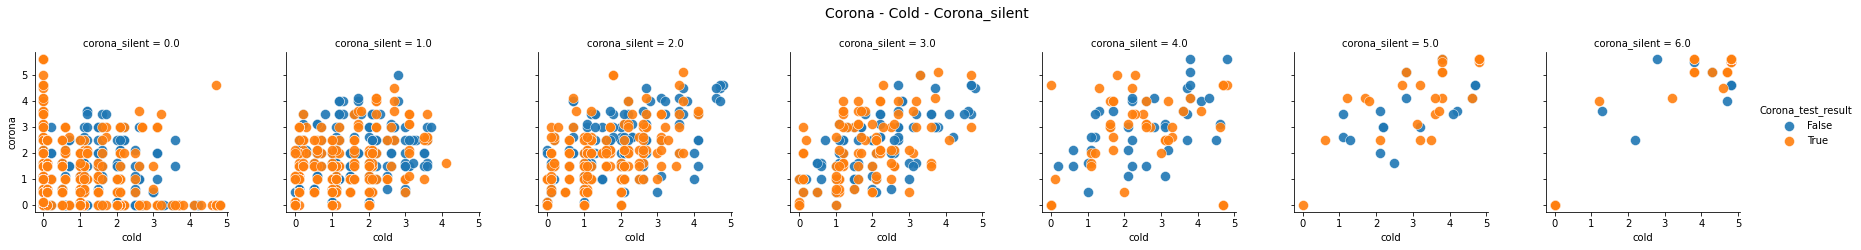

In [327]:
g = sb.FacetGrid(vis3d, col="corona_silent", hue='corona_test_result',
                  aspect=1, size=3.5)
g.map(plt.scatter, "cold", "corona", alpha=0.9, 
      edgecolor='white', linewidth=0.5, s=100)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Corona - Cold - Corona_silent', fontsize=14)
l = g.add_legend(title='Corona_test_result')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


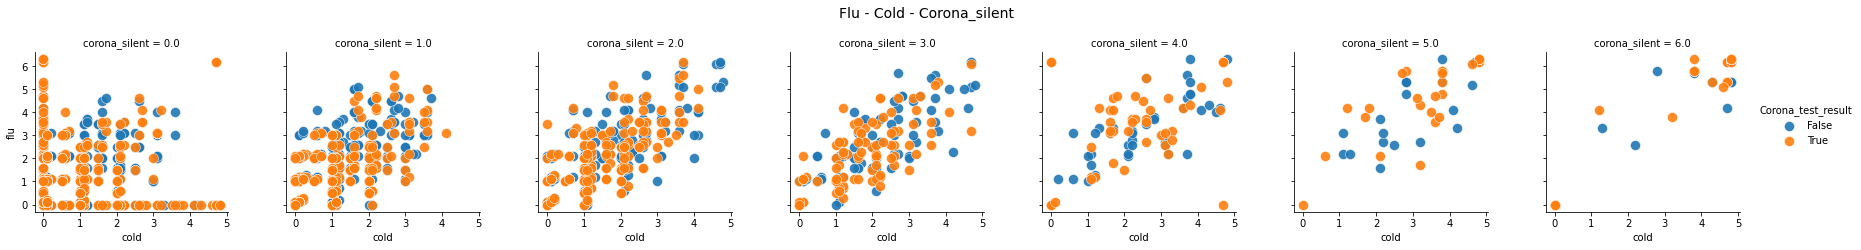

In [328]:
g = sb.FacetGrid(vis3d, col="corona_silent", hue='corona_test_result',
                  aspect=1, size=3.5)
g.map(plt.scatter, "cold", "flu", alpha=0.9, 
      edgecolor='white', linewidth=0.5, s=100)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Flu - Cold - Corona_silent', fontsize=14)
l = g.add_legend(title='Corona_test_result')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


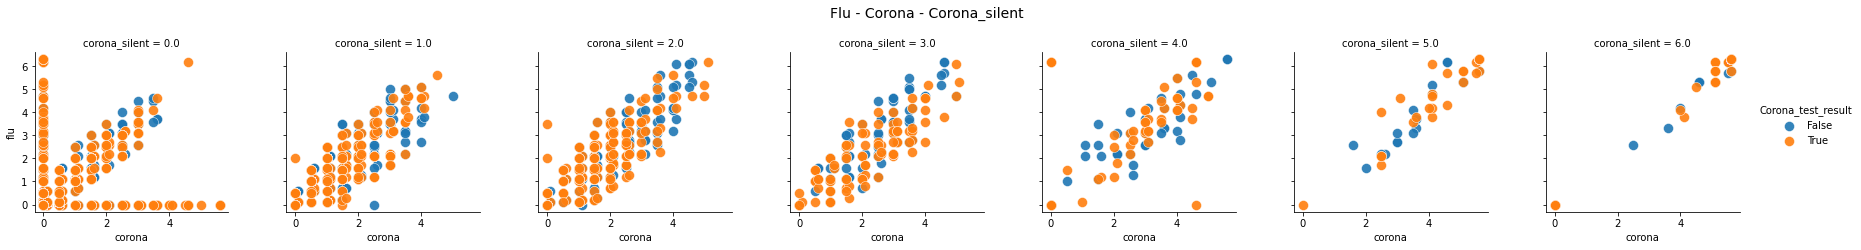

In [329]:
g = sb.FacetGrid(vis3d, col="corona_silent", hue='corona_test_result',
                  aspect=1, size=3.5)
g.map(plt.scatter, "corona", "flu", alpha=0.9, 
      edgecolor='white', linewidth=0.5, s=100)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Flu - Corona - Corona_silent', fontsize=14)
l = g.add_legend(title='Corona_test_result')